In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path=%pwd
print(path)

/content


In [3]:
!unzip "/content/drive/My Drive/archive.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import PIL
from tensorflow.keras import layers
import tensorflow as tf
import pickle
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from keras.utils.np_utils import to_categorical #for one hot encoding of data

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


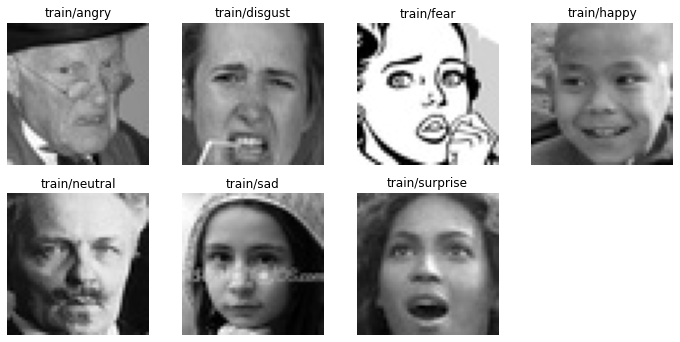

In [29]:
train_dir='train'
val_dir='test'

angry_dir='train/angry'
disgust_dir='train/disgust'
fear_dir='train/fear'
happy_dir='train/happy'
neutral_dir='train/neutral'
sad_dir='train/sad'
suprise_dir='train/surprise'

listt=[]
listt.extend([angry_dir,disgust_dir,fear_dir,happy_dir,neutral_dir,sad_dir,suprise_dir])

plt.figure(figsize=(12,12))
for i in range(7):
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    length = len(os.listdir(listt[i]))
    random_no=random.randint(1,length)
    title=listt[i]
    img=mpimg.imread(os.path.join(path,(listt[i]),(os.listdir(listt[i]))[random_no]))
    plt.imshow(img,cmap='gray')
    plt.text(25,-2,(listt[i])[20:],fontsize=20,horizontalalignment='center')
    plt.title(title)


In [30]:
no_of_Classes = len(listt)
images = []
classId = []

In [31]:
for i in range (0,no_of_Classes):
  # p_Path = os.listdir(path+'/'+str(listt[i])
  for j in range(len(os.listdir(listt[i]))):
    img=cv2.imread(os.path.join(path,(listt[i]),(os.listdir(listt[i]))[j]),0)
    images.append(img)
    classId.append(i)
  print(i,end=" ") 
print(len(images)) 
print(np.unique(classId)) 

0 1 2 3 4 5 6 28709
[0 1 2 3 4 5 6]


In [37]:
images = np.array(images)
classId = np.array(classId)
print(images.shape)
print(classId.shape)
print(np.unique(classId))

(28709, 48, 48)
(28709,)
[0 1 2 3 4 5 6]


In [38]:
images = np.expand_dims(images, axis=-1)
print(images.shape)

(28709, 48, 48, 1)


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_Test, y_train, y_Test = train_test_split(images,classId,test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test,y_Test, test_size = 0.5, shuffle = True)
print(X_train.shape, y_train.shape)
print(X_Test.shape, y_Test.shape)
print(X_val.shape, y_val.shape)

(25838, 48, 48, 1) (25838,)
(1436, 48, 48, 1) (1436,)
(1435, 48, 48, 1) (1435,)


In [40]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6])

In [41]:
no_of_images=[]
for i in range (0,no_of_Classes):
  no_of_images.append(len(np.where(y_train==i)[0]))

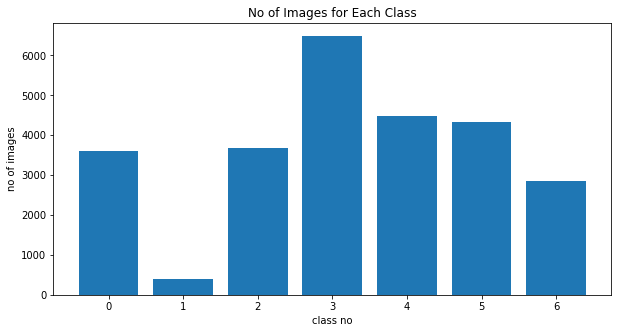

In [42]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(0,no_of_Classes,1),no_of_images)
plt.title("No of Images for Each Class")
plt.xlabel('class no')
plt.ylabel('no of images')
plt.show()

In [43]:
y_train = to_categorical(y_train,no_of_Classes)
y_test = to_categorical(y_Test,no_of_Classes)
y_validation = to_categorical(y_val,no_of_Classes)

In [44]:
X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [45]:
print(X_train.shape)

(25838, 48, 48, 1)


In [46]:
print(y_train.shape,y_test.shape,y_validation.shape)

(25838, 7) (1436, 7) (1435, 7)


In [47]:
train_datagen = ImageDataGenerator(
rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode = "nearest", 
    vertical_flip=True,
)

In [48]:

def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [49]:
 
input_shape = (48, 48, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# Average Pooling
X = AveragePooling2D((2, 2), name = 'Average_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(7, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_emotion = Model( inputs= X_input, outputs = X)

model_emotion.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 54, 54, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 24, 24, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [50]:
model_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [51]:

# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)
# Saving the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [55]:
history = model_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),validation_data=(X_val, y_validation), steps_per_epoch=len(X_train) // 64,epochs= 150, callbacks=[checkpointer,learning_rate_reduction,earlystopping])


Epoch 1/150
403/403 [==============================] - 15s 32ms/step - loss: 1.9122 - accuracy: 0.2605 - val_loss: 1.8516 - val_accuracy: 0.2383

Epoch 00001: val_loss improved from inf to 1.85161, saving model to FacialExpression_weights.hdf5
Epoch 2/150
403/403 [==============================] - 14s 34ms/step - loss: 1.7372 - accuracy: 0.3287 - val_loss: 1.8657 - val_accuracy: 0.3031

Epoch 00002: val_loss did not improve from 1.85161
Epoch 3/150
403/403 [==============================] - 14s 34ms/step - loss: 1.6532 - accuracy: 0.3687 - val_loss: 1.8766 - val_accuracy: 0.2495

Epoch 00003: val_loss did not improve from 1.85161
Epoch 4/150
403/403 [==============================] - 13s 32ms/step - loss: 1.5779 - accuracy: 0.3972 - val_loss: 2.1166 - val_accuracy: 0.3122

Epoch 00004: val_loss did not improve from 1.85161
Epoch 5/150
403/403 [==============================] - 13s 32ms/step - loss: 1.5239 - accuracy: 0.4184 - val_loss: 2.1895 - val_accuracy: 0.2111

Epoch 00005: val_lo

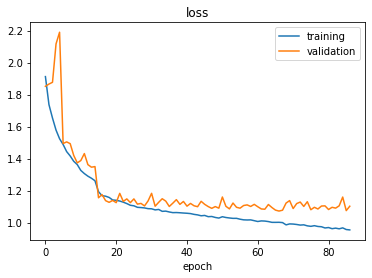

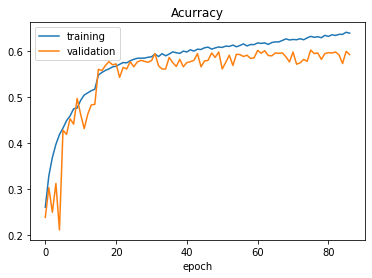

Test Score: 1.1352510452270508
Test Accuracy: 0.5779944062232971


In [56]:
plt.figure(1)
plt.plot(history .history['loss'])
plt.plot(history .history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history .history['accuracy'])
plt.plot(history .history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model_emotion.evaluate(X_Test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])